In [1]:
"""
Lab 9: Deutsch-Jozsa Algorithm Implementation
Part 1: Setup and Oracle Creation
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit_aer import AerSimulator
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("="*70)
print("DEUTSCH-JOZSA ALGORITHM IMPLEMENTATION")
print("="*70)
print("\n📚 THEORY:")
print("-" * 70)
print("The Deutsch-Jozsa algorithm determines whether a function f:{0,1}^n → {0,1}")
print("is CONSTANT (same output for all inputs) or BALANCED (half 0s, half 1s)")
print("with only ONE query, compared to 2^(n-1)+1 classical queries in worst case.")
print("-" * 70)

# =============================================================================
# BLOCK 1: CREATE ORACLE FUNCTIONS
# =============================================================================

def create_constant_oracle(n_qubits, output_value=0):
    """
    Creates a constant oracle that outputs the same value for all inputs.
    
    Parameters:
    - n_qubits: number of input qubits
    - output_value: 0 or 1 (constant output)
    """
    oracle = QuantumCircuit(n_qubits + 1, name='Constant Oracle')
    
    if output_value == 1:
        # Flip the output qubit for constant-1 function
        oracle.x(n_qubits)
    
    # If output_value == 0, do nothing (identity operation)
    
    return oracle


def create_balanced_oracle(n_qubits, pattern=None):
    """
    Creates a balanced oracle that outputs 0 for half inputs and 1 for the other half.
    
    Parameters:
    - n_qubits: number of input qubits
    - pattern: binary string or None (random if None)
    """
    oracle = QuantumCircuit(n_qubits + 1, name='Balanced Oracle')
    
    if pattern is None:
        # Generate random balanced function
        pattern = ''.join(np.random.choice(['0', '1'], n_qubits))
    
    # Apply CNOT gates based on pattern
    for i, bit in enumerate(pattern):
        if bit == '1':
            oracle.x(i)
    
    # Apply CNOT from all input qubits to output qubit
    for i in range(n_qubits):
        oracle.cx(i, n_qubits)
    
    # Reverse the X gates
    for i, bit in enumerate(pattern):
        if bit == '1':
            oracle.x(i)
    
    return oracle, pattern



DEUTSCH-JOZSA ALGORITHM IMPLEMENTATION

📚 THEORY:
----------------------------------------------------------------------
The Deutsch-Jozsa algorithm determines whether a function f:{0,1}^n → {0,1}
is CONSTANT (same output for all inputs) or BALANCED (half 0s, half 1s)
with only ONE query, compared to 2^(n-1)+1 classical queries in worst case.
----------------------------------------------------------------------




🔧 BLOCK 1: ORACLE CREATION

📊 Creating oracles for n=3 input qubits...

✓ Constant Oracle (output=0) created
✓ Constant Oracle (output=1) created
✓ Balanced Oracle created with pattern: 000

💾 Oracle circuits saved as 'oracle_circuits.png'


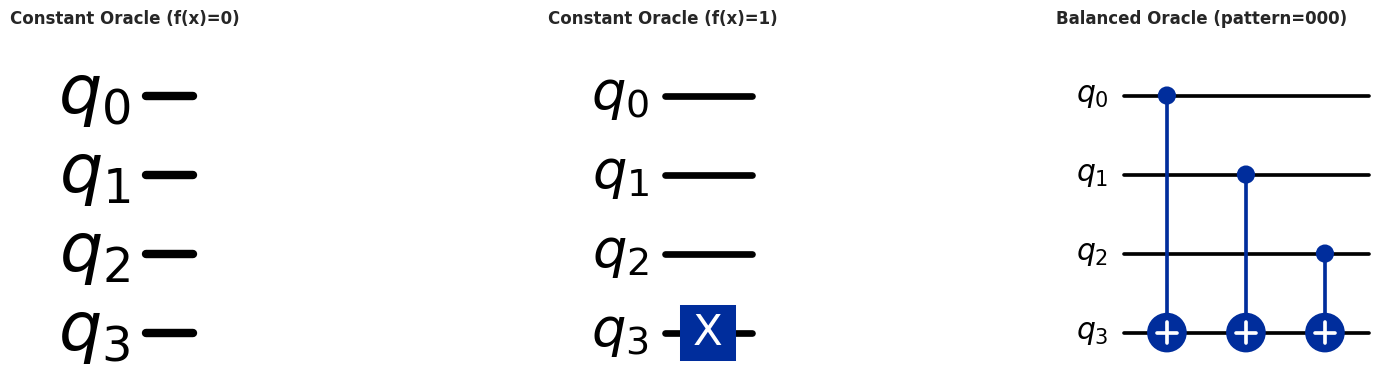

In [2]:

# =============================================================================
# BLOCK 2: VISUALIZE ORACLE TYPES
# =============================================================================

print("\n\n🔧 BLOCK 1: ORACLE CREATION")
print("="*70)

# Set number of qubits
n = 3  # Number of input qubits

# Create both types of oracles
print(f"\n📊 Creating oracles for n={n} input qubits...")

# Constant oracle (output = 0)
constant_oracle_0 = create_constant_oracle(n, output_value=0)
print(f"\n✓ Constant Oracle (output=0) created")

# Constant oracle (output = 1)
constant_oracle_1 = create_constant_oracle(n, output_value=1)
print(f"✓ Constant Oracle (output=1) created")

# Balanced oracle
balanced_oracle, balance_pattern = create_balanced_oracle(n)
print(f"✓ Balanced Oracle created with pattern: {balance_pattern}")

# Visualize all oracles
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

oracles = [
    (constant_oracle_0, "Constant Oracle (f(x)=0)"),
    (constant_oracle_1, "Constant Oracle (f(x)=1)"),
    (balanced_oracle, f"Balanced Oracle (pattern={balance_pattern})")
]

for idx, (oracle, title) in enumerate(oracles):
    oracle.draw('mpl', ax=axes[idx], style='iqp')
    axes[idx].set_title(title, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('oracle_circuits.png', dpi=300, bbox_inches='tight')
print("\n💾 Oracle circuits saved as 'oracle_circuits.png'")
plt.show()





🔍 BLOCK 2: ORACLE BEHAVIOR ANALYSIS

📋 Constant Oracle (f(x)=0) - Truth Table:
----------------------------------------
  f(000) = 0
  f(001) = 0
  f(010) = 0
  f(011) = 0
  f(100) = 0
  f(101) = 0
  f(110) = 0
  f(111) = 0

📋 Balanced Oracle - Truth Table:
----------------------------------------
  Pattern: 000
  f(000) = 0
  f(001) = 0
  f(010) = 0
  f(011) = 0
  f(100) = 0
  f(101) = 0
  f(110) = 0
  f(111) = 0

💾 Oracle output analysis saved as 'oracle_outputs.png'


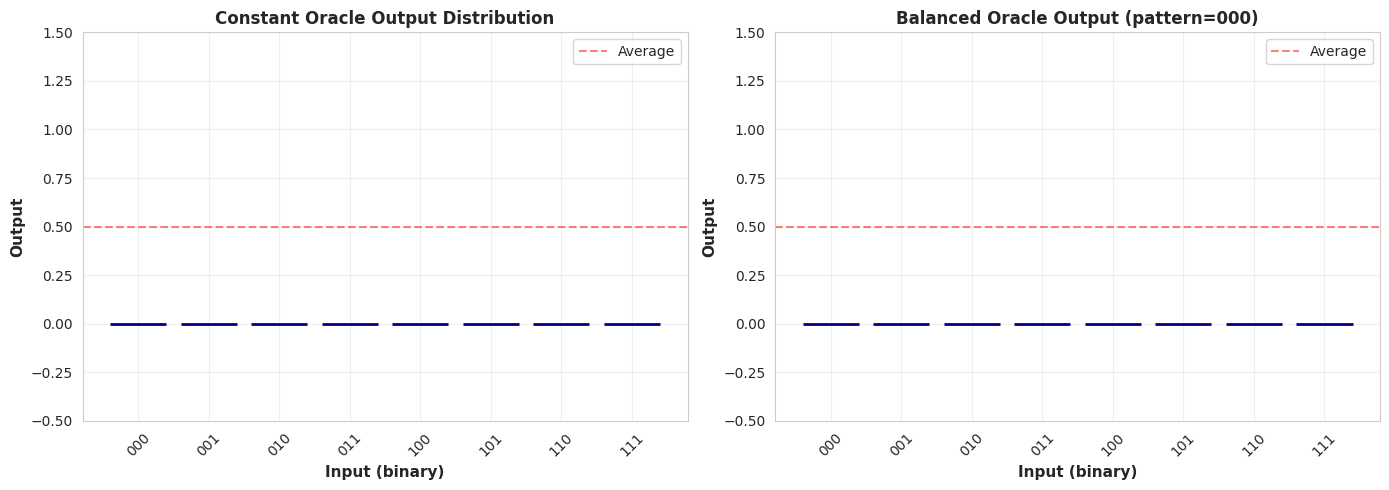


📊 STATISTICAL SUMMARY:
----------------------------------------
Constant Oracle:
  - Total inputs: 8
  - Outputs = 0: 8
  - Outputs = 1: 0
  - Balance: 0% ones

Balanced Oracle:
  - Total inputs: 8
  - Outputs = 0: 8
  - Outputs = 1: 0
  - Balance: 0.0% ones

✅ PART 1 COMPLETE: Oracles created and analyzed!


In [3]:
# =============================================================================
# BLOCK 3: ANALYZE ORACLE BEHAVIOR
# =============================================================================

print("\n\n🔍 BLOCK 2: ORACLE BEHAVIOR ANALYSIS")
print("="*70)

def test_oracle_classical(oracle_func, n_qubits, is_balanced=False, pattern=None):
    """Test oracle with all possible classical inputs"""
    results = {}
    
    for i in range(2**n_qubits):
        binary_input = format(i, f'0{n_qubits}b')
        
        if is_balanced:
            # Calculate output for balanced oracle
            xor_result = sum([int(binary_input[j]) for j in range(n_qubits) 
                             if pattern[j] == '1']) % 2
            output = xor_result
        else:
            # Constant oracle
            output = oracle_func(n_qubits).name.split('=')[1][0] if '=' in str(oracle_func) else 0
        
        results[binary_input] = output
    
    return results

# Test constant oracle
print("\n📋 Constant Oracle (f(x)=0) - Truth Table:")
print("-" * 40)
for i in range(min(8, 2**n)):  # Show first 8 entries
    binary = format(i, f'0{n}b')
    print(f"  f({binary}) = 0")
if 2**n > 8:
    print(f"  ... and {2**n - 8} more entries (all output 0)")

print("\n📋 Balanced Oracle - Truth Table:")
print("-" * 40)
print(f"  Pattern: {balance_pattern}")
balanced_results = {}
for i in range(2**n):
    binary = format(i, f'0{n}b')
    output = sum([int(binary[j]) for j in range(n) if balance_pattern[j] == '1']) % 2
    balanced_results[binary] = output
    if i < 8:
        print(f"  f({binary}) = {output}")
if 2**n > 8:
    print(f"  ... and {2**n - 8} more entries")

# Visualize truth table
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Constant oracle visualization
inputs = [format(i, f'0{n}b') for i in range(2**n)]
constant_outputs = [0] * (2**n)

axes[0].bar(range(len(inputs)), constant_outputs, color='skyblue', edgecolor='navy', linewidth=2)
axes[0].set_xlabel('Input (binary)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Output', fontsize=11, fontweight='bold')
axes[0].set_title('Constant Oracle Output Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(0, len(inputs), max(1, len(inputs)//8)))
axes[0].set_xticklabels([inputs[i] for i in range(0, len(inputs), max(1, len(inputs)//8))], rotation=45)
axes[0].set_ylim(-0.5, 1.5)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Average')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Balanced oracle visualization
balanced_output_list = [balanced_results[inp] for inp in inputs]
colors = ['lightcoral' if x == 1 else 'lightgreen' for x in balanced_output_list]

axes[1].bar(range(len(inputs)), balanced_output_list, color=colors, edgecolor='navy', linewidth=2)
axes[1].set_xlabel('Input (binary)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Output', fontsize=11, fontweight='bold')
axes[1].set_title(f'Balanced Oracle Output (pattern={balance_pattern})', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(0, len(inputs), max(1, len(inputs)//8)))
axes[1].set_xticklabels([inputs[i] for i in range(0, len(inputs), max(1, len(inputs)//8))], rotation=45)
axes[1].set_ylim(-0.5, 1.5)
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Average')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('oracle_outputs.png', dpi=300, bbox_inches='tight')
print("\n💾 Oracle output analysis saved as 'oracle_outputs.png'")
plt.show()

# Statistical summary
print("\n📊 STATISTICAL SUMMARY:")
print("-" * 40)
print(f"Constant Oracle:")
print(f"  - Total inputs: {2**n}")
print(f"  - Outputs = 0: {2**n}")
print(f"  - Outputs = 1: 0")
print(f"  - Balance: 0% ones")

ones_count = sum(balanced_output_list)
print(f"\nBalanced Oracle:")
print(f"  - Total inputs: {2**n}")
print(f"  - Outputs = 0: {2**n - ones_count}")
print(f"  - Outputs = 1: {ones_count}")
print(f"  - Balance: {ones_count/(2**n)*100:.1f}% ones")

print("\n" + "="*70)
print("✅ PART 1 COMPLETE: Oracles created and analyzed!")
print("="*70)



🚀 BLOCK 3: DEUTSCH-JOZSA ALGORITHM IMPLEMENTATION

🎲 Randomly selected function type: CONSTANT
   Output value: 0

✓ Deutsch-Jozsa circuit created successfully!
💾 Complete circuit saved as 'dj_complete_circuit.png'


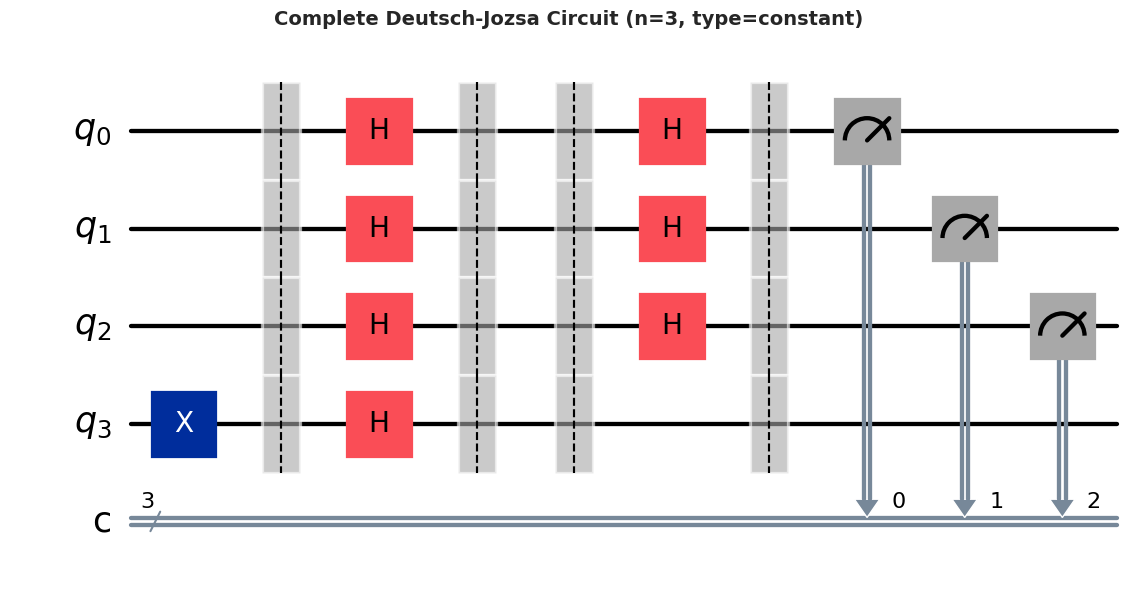



📊 BLOCK 4: STEP-BY-STEP STATE EVOLUTION

Step 0: Initial State |00...01⟩
  Dominant state: |1000⟩ with probability 1.0000

Step 1: After Hadamard Gates (Superposition)
  Dominant state: |0000⟩ with probability 0.0625

Step 2: After Oracle Application
  Dominant state: |0000⟩ with probability 0.0625

Step 3: After Final Hadamard Gates
  Dominant state: |0000⟩ with probability 0.5000

💾 State evolution saved as 'dj_state_evolution.png'


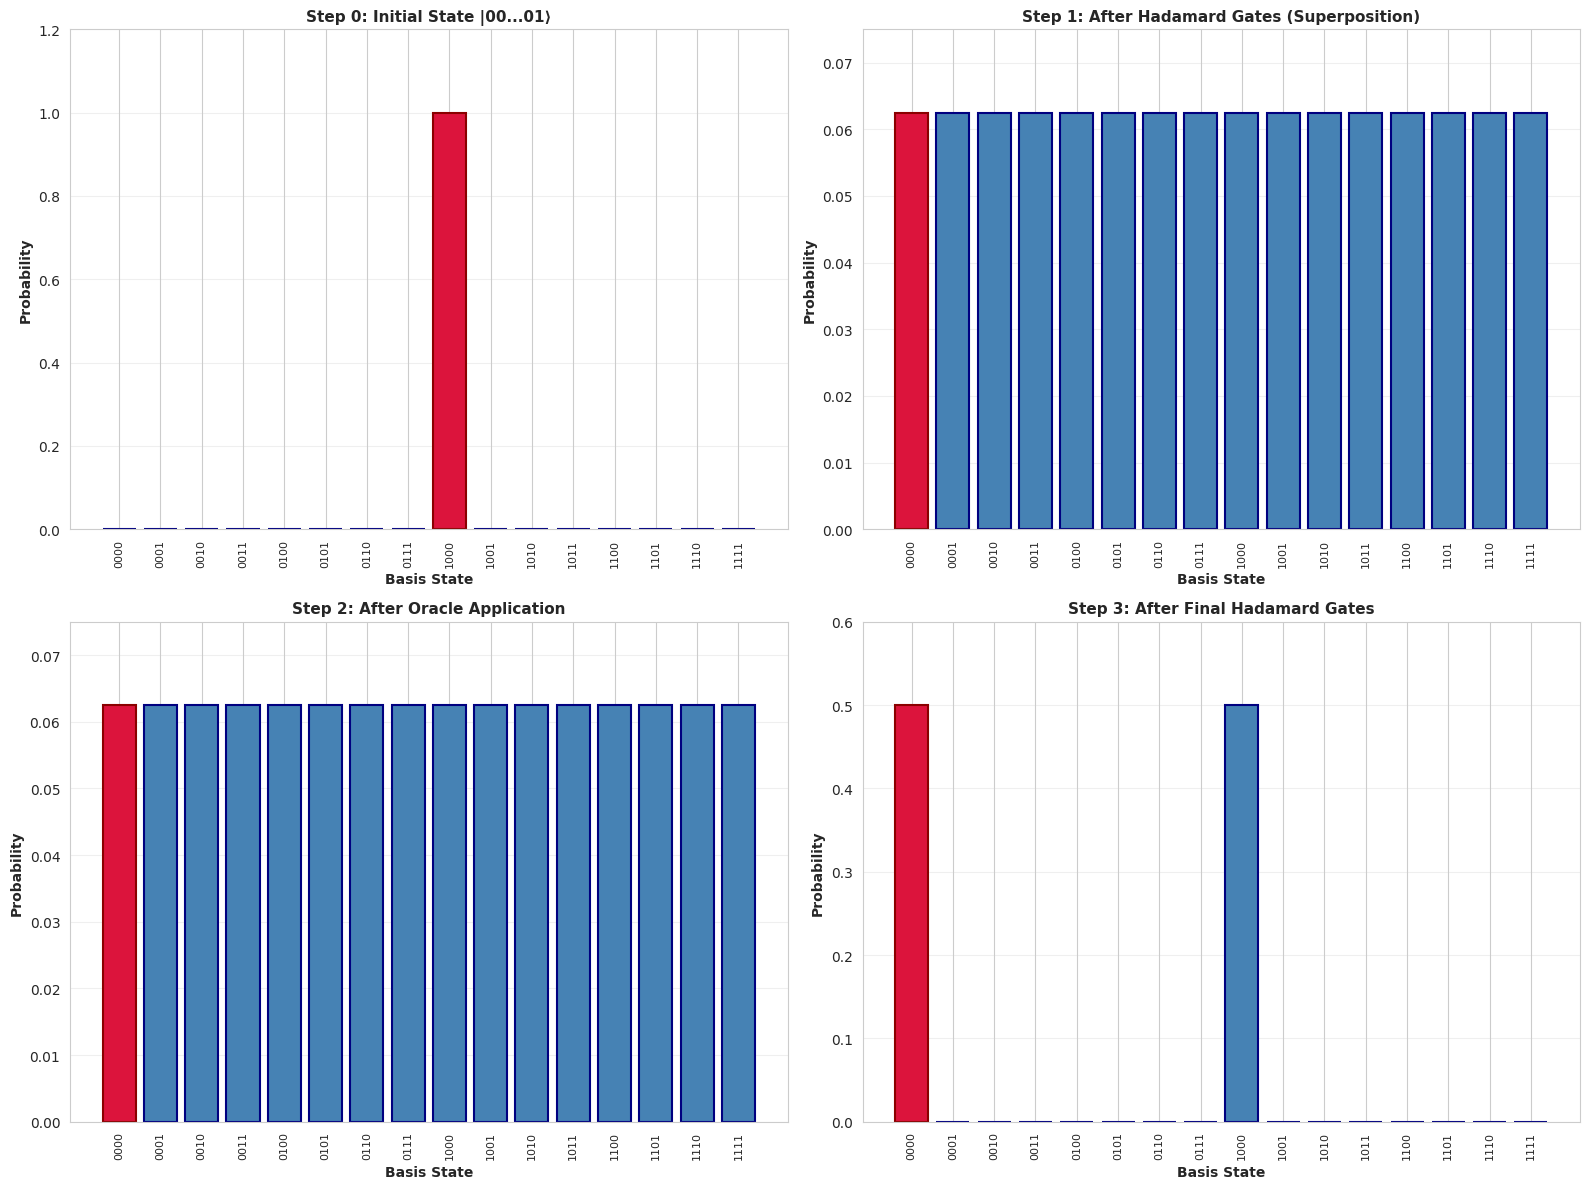



⚡ BLOCK 5: CIRCUIT EXECUTION AND MEASUREMENT

🔬 Executing circuit with 1024 shots...
✓ Simulation complete!

📊 MEASUREMENT RESULTS:
----------------------------------------
  |000⟩: 1024 times (100.00%)

🎯 ALGORITHM DECISION:
----------------------------------------
  ✓ Measured all zeros: |000⟩
  → Function is CONSTANT

✅ VERIFICATION:
  - Actual function type: CONSTANT
  - Predicted type: CONSTANT
  - Correct: YES! 🎉

💾 Results analysis saved as 'dj_results_analysis.png'


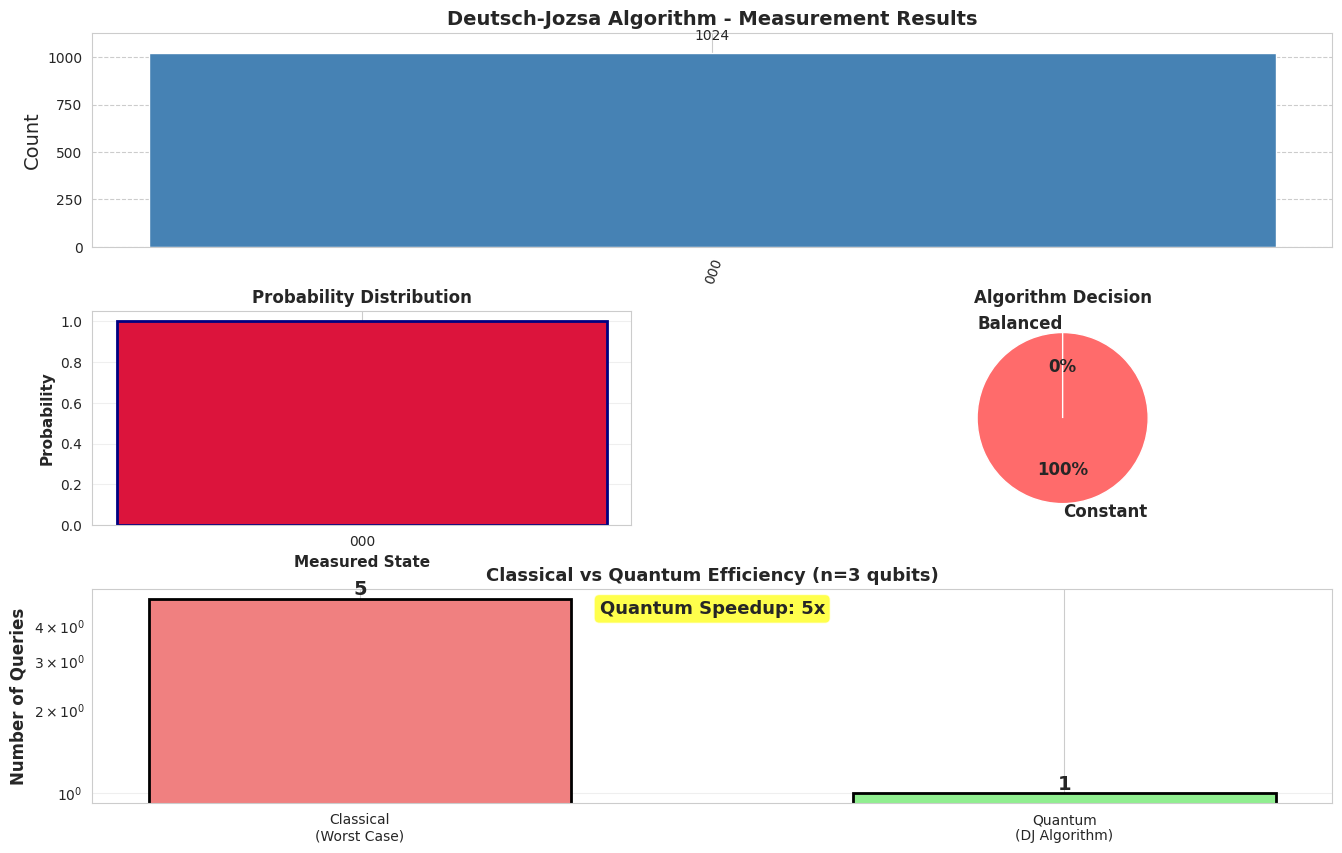


✅ DEUTSCH-JOZSA ALGORITHM COMPLETE!

📈 SUMMARY:
  - Input qubits: 3
  - Function type: CONSTANT
  - Queries needed (classical): 5
  - Queries needed (quantum): 1
  - Speedup factor: 5x
  - Algorithm result: CONSTANT
  - Verification: CORRECT ✓


In [4]:
"""
Lab 9: Deutsch-Jozsa Algorithm Implementation
Part 2: Complete Algorithm Implementation

INSTRUCTIONS:
1. Run Part 1 first to understand oracles
2. Run this Part 2 for the complete DJ algorithm
3. Then run Part 3 for comprehensive testing
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

# =============================================================================
# ORACLE CREATION FUNCTIONS (from Part 1)
# =============================================================================

def create_constant_oracle(n_qubits, output_value=0):
    """Creates a constant oracle"""
    oracle = QuantumCircuit(n_qubits + 1, name='Const')
    if output_value == 1:
        oracle.x(n_qubits)
    return oracle

def create_balanced_oracle(n_qubits, pattern=None):
    """Creates a balanced oracle"""
    oracle = QuantumCircuit(n_qubits + 1, name='Balanced')
    if pattern is None:
        pattern = ''.join(np.random.choice(['0', '1'], n_qubits))
    
    for i, bit in enumerate(pattern):
        if bit == '1':
            oracle.x(i)
    
    for i in range(n_qubits):
        oracle.cx(i, n_qubits)
    
    for i, bit in enumerate(pattern):
        if bit == '1':
            oracle.x(i)
    
    return oracle, pattern

# =============================================================================
# BLOCK 4: DEUTSCH-JOZSA ALGORITHM IMPLEMENTATION
# =============================================================================

def deutsch_jozsa_algorithm(oracle, n_qubits):
    """
    Implements the complete Deutsch-Jozsa algorithm.
    
    Parameters:
    - oracle: Quantum circuit implementing the query gate
    - n_qubits: Number of input qubits
    
    Returns:
    - circuit: Complete DJ quantum circuit
    """
    
    # Create quantum and classical registers
    qr = QuantumRegister(n_qubits + 1, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    circuit = QuantumCircuit(qr, cr)
    
    # Step 1: Initialize qubits
    # Input qubits start in |0⟩, output qubit in |1⟩
    circuit.x(n_qubits)  # Set output qubit to |1⟩
    circuit.barrier()
    
    # Step 2: Apply Hadamard to all qubits
    for i in range(n_qubits + 1):
        circuit.h(i)
    circuit.barrier()
    
    # Step 3: Apply the oracle
    circuit.compose(oracle, inplace=True)
    circuit.barrier()
    
    # Step 4: Apply Hadamard to input qubits
    for i in range(n_qubits):
        circuit.h(i)
    circuit.barrier()
    
    # Step 5: Measure input qubits
    circuit.measure(range(n_qubits), range(n_qubits))
    
    return circuit

print("\n\n🚀 BLOCK 3: DEUTSCH-JOZSA ALGORITHM IMPLEMENTATION")
print("="*70)

# Set parameters
n = 3  # Number of input qubits

# Choose a random function type
function_type = np.random.choice(['constant', 'balanced'])
print(f"\n🎲 Randomly selected function type: {function_type.upper()}")

if function_type == 'constant':
    output_val = np.random.choice([0, 1])
    oracle = create_constant_oracle(n, output_val)
    print(f"   Output value: {output_val}")
    pattern = None
else:
    oracle, pattern = create_balanced_oracle(n)
    print(f"   Pattern: {pattern}")

# Create the Deutsch-Jozsa circuit
dj_circuit = deutsch_jozsa_algorithm(oracle, n)

print("\n✓ Deutsch-Jozsa circuit created successfully!")

# Visualize the complete circuit
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
dj_circuit.draw('mpl', ax=ax, style='iqp', fold=-1)
ax.set_title(f'Complete Deutsch-Jozsa Circuit (n={n}, type={function_type})', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('dj_complete_circuit.png', dpi=300, bbox_inches='tight')
print("💾 Complete circuit saved as 'dj_complete_circuit.png'")
plt.show()

# =============================================================================
# BLOCK 5: STEP-BY-STEP VISUALIZATION
# =============================================================================

print("\n\n📊 BLOCK 4: STEP-BY-STEP STATE EVOLUTION")
print("="*70)

def visualize_statevector(circuit, title, ax):
    """Visualize the statevector at a given point"""
    sv = Statevector.from_instruction(circuit)
    probs = sv.probabilities()
    
    # Get basis states
    n_qubits = int(np.log2(len(probs)))
    labels = [format(i, f'0{n_qubits}b') for i in range(len(probs))]
    
    # Plot
    bars = ax.bar(range(len(probs)), probs, color='steelblue', edgecolor='navy', linewidth=1.5)
    ax.set_xlabel('Basis State', fontsize=10, fontweight='bold')
    ax.set_ylabel('Probability', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks(range(0, len(probs), max(1, len(probs)//16)))
    ax.set_xticklabels([labels[i] for i in range(0, len(probs), max(1, len(probs)//16))], 
                       rotation=90, fontsize=8)
    ax.set_ylim(0, max(probs) * 1.2 if max(probs) > 0 else 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Color the highest probability bar
    max_idx = np.argmax(probs)
    bars[max_idx].set_color('crimson')
    bars[max_idx].set_edgecolor('darkred')
    
    return max_idx, labels[max_idx], probs[max_idx]

# Create step-by-step circuits
steps = []

# Step 0: Initial state
qr = QuantumRegister(n + 1, 'q')
initial = QuantumCircuit(qr)
initial.x(n)
steps.append((initial, "Step 0: Initial State |00...01⟩"))

# Step 1: After first Hadamards
after_h1 = initial.copy()
for i in range(n + 1):
    after_h1.h(i)
steps.append((after_h1, "Step 1: After Hadamard Gates (Superposition)"))

# Step 2: After Oracle
after_oracle = after_h1.copy()
after_oracle.compose(oracle, inplace=True)
steps.append((after_oracle, "Step 2: After Oracle Application"))

# Step 3: After final Hadamards
after_h2 = after_oracle.copy()
for i in range(n):
    after_h2.h(i)
steps.append((after_h2, "Step 3: After Final Hadamard Gates"))

# Visualize all steps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

results = []
for idx, (circuit, title) in enumerate(steps):
    max_idx, state, prob = visualize_statevector(circuit, title, axes[idx])
    results.append((state, prob))
    print(f"\n{title}")
    print(f"  Dominant state: |{state}⟩ with probability {prob:.4f}")

plt.tight_layout()
plt.savefig('dj_state_evolution.png', dpi=300, bbox_inches='tight')
print("\n💾 State evolution saved as 'dj_state_evolution.png'")
plt.show()

# =============================================================================
# BLOCK 6: EXECUTE AND MEASURE
# =============================================================================

print("\n\n⚡ BLOCK 5: CIRCUIT EXECUTION AND MEASUREMENT")
print("="*70)

# Run simulation
simulator = AerSimulator()
compiled_circuit = transpile(dj_circuit, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

print(f"\n🔬 Executing circuit with 1024 shots...")
print(f"✓ Simulation complete!")

# Analyze results
print(f"\n📊 MEASUREMENT RESULTS:")
print("-" * 40)
for outcome, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / 1024) * 100
    print(f"  |{outcome}⟩: {count} times ({percentage:.2f}%)")

# Determine if constant or balanced
measured_state = max(counts, key=counts.get)
is_all_zeros = (measured_state == '0' * n)

print(f"\n🎯 ALGORITHM DECISION:")
print("-" * 40)
if is_all_zeros:
    predicted = "CONSTANT"
    print(f"  ✓ Measured all zeros: |{'0'*n}⟩")
    print(f"  → Function is CONSTANT")
else:
    predicted = "BALANCED"
    print(f"  ✓ Measured non-zero state: |{measured_state}⟩")
    print(f"  → Function is BALANCED")

print(f"\n✅ VERIFICATION:")
print(f"  - Actual function type: {function_type.upper()}")
print(f"  - Predicted type: {predicted}")
print(f"  - Correct: {'YES! 🎉' if predicted.lower() == function_type else 'NO ❌'}")

# =============================================================================
# BLOCK 7: VISUALIZATION OF RESULTS
# =============================================================================

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Histogram of measurements
ax1 = fig.add_subplot(gs[0, :])
plot_histogram(counts, ax=ax1, color='steelblue', title='Measurement Results (1024 shots)')
ax1.set_title('Deutsch-Jozsa Algorithm - Measurement Results', fontsize=14, fontweight='bold')

# Probability distribution
ax2 = fig.add_subplot(gs[1, 0])
states = list(counts.keys())
probs = [counts[s]/1024 for s in states]
colors = ['crimson' if s == measured_state else 'steelblue' for s in states]
ax2.bar(states, probs, color=colors, edgecolor='navy', linewidth=2)
ax2.set_xlabel('Measured State', fontsize=11, fontweight='bold')
ax2.set_ylabel('Probability', fontsize=11, fontweight='bold')
ax2.set_title('Probability Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Decision visualization
ax3 = fig.add_subplot(gs[1, 1])
decision_data = {'Constant': 0, 'Balanced': 0}
if predicted == 'CONSTANT':
    decision_data['Constant'] = 1
else:
    decision_data['Balanced'] = 1

colors_pie = ['#ff6b6b' if predicted == 'CONSTANT' else '#95e1d3',
              '#95e1d3' if predicted == 'BALANCED' else '#ff6b6b']
ax3.pie([decision_data['Constant'], decision_data['Balanced']], 
        labels=['Constant', 'Balanced'],
        colors=colors_pie,
        autopct='%1.0f%%',
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
ax3.set_title('Algorithm Decision', fontsize=12, fontweight='bold')

# Classical vs Quantum comparison
ax4 = fig.add_subplot(gs[2, :])
query_counts = ['Classical\n(Worst Case)', 'Quantum\n(DJ Algorithm)']
queries = [2**(n-1) + 1, 1]
colors_bar = ['lightcoral', 'lightgreen']
bars = ax4.bar(query_counts, queries, color=colors_bar, edgecolor='black', linewidth=2, width=0.6)
ax4.set_ylabel('Number of Queries', fontsize=12, fontweight='bold')
ax4.set_title(f'Classical vs Quantum Efficiency (n={n} qubits)', fontsize=13, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, queries):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add speedup annotation
speedup = queries[0] / queries[1]
ax4.text(0.5, 0.95, f'Quantum Speedup: {speedup:.0f}x', 
         transform=ax4.transAxes,
         fontsize=13, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
         ha='center', va='top')

plt.savefig('dj_results_analysis.png', dpi=300, bbox_inches='tight')
print("\n💾 Results analysis saved as 'dj_results_analysis.png'")
plt.show()

print("\n" + "="*70)
print("✅ DEUTSCH-JOZSA ALGORITHM COMPLETE!")
print("="*70)
print(f"\n📈 SUMMARY:")
print(f"  - Input qubits: {n}")
print(f"  - Function type: {function_type.upper()}")
print(f"  - Queries needed (classical): {2**(n-1) + 1}")
print(f"  - Queries needed (quantum): 1")
print(f"  - Speedup factor: {2**(n-1) + 1}x")
print(f"  - Algorithm result: {predicted}")
print(f"  - Verification: {'CORRECT ✓' if predicted.lower() == function_type else 'INCORRECT ✗'}")
print("="*70)

In [5]:
"""
Lab 9: Deutsch-Jozsa Algorithm Implementation
Part 3: Comprehensive Testing with Multiple Cases
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("husl")

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def create_constant_oracle(n_qubits, output_value=0):
    """Creates a constant oracle"""
    oracle = QuantumCircuit(n_qubits + 1, name=f'Const-{output_value}')
    if output_value == 1:
        oracle.x(n_qubits)
    return oracle

def create_balanced_oracle(n_qubits, pattern=None):
    """Creates a balanced oracle"""
    oracle = QuantumCircuit(n_qubits + 1, name='Balanced')
    if pattern is None:
        pattern = ''.join(np.random.choice(['0', '1'], n_qubits))
    
    for i, bit in enumerate(pattern):
        if bit == '1':
            oracle.x(i)
    
    for i in range(n_qubits):
        oracle.cx(i, n_qubits)
    
    for i, bit in enumerate(pattern):
        if bit == '1':
            oracle.x(i)
    
    return oracle, pattern

def deutsch_jozsa_algorithm(oracle, n_qubits):
    """Implements the complete Deutsch-Jozsa algorithm"""
    qr = QuantumRegister(n_qubits + 1, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    circuit = QuantumCircuit(qr, cr)
    
    circuit.x(n_qubits)
    circuit.barrier()
    
    for i in range(n_qubits + 1):
        circuit.h(i)
    circuit.barrier()
    
    circuit.compose(oracle, inplace=True)
    circuit.barrier()
    
    for i in range(n_qubits):
        circuit.h(i)
    circuit.barrier()
    
    circuit.measure(range(n_qubits), range(n_qubits))
    
    return circuit

def run_dj_algorithm(oracle, n_qubits, shots=1024):
    """Run the DJ algorithm and return results"""
    circuit = deutsch_jozsa_algorithm(oracle, n_qubits)
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # Determine result
    measured_state = max(counts, key=counts.get)
    is_constant = (measured_state == '0' * n_qubits)
    
    return counts, is_constant, measured_state



In [6]:
# =============================================================================
# BLOCK 8: MULTIPLE TEST CASES
# =============================================================================

print("\n\n🧪 BLOCK 6: TESTING MULTIPLE CASES")
print("="*70)

# Test configuration
n_qubits = 3
n_tests = 8  # Test 8 different functions

# Store results
test_results = []
all_circuits = []

print(f"\n🔬 Running {n_tests} test cases with {n_qubits} input qubits...\n")

for test_num in range(n_tests):
    # Randomly choose function type
    is_constant_func = (test_num % 2 == 0)  # Alternate between constant and balanced
    
    if is_constant_func:
        output_val = np.random.choice([0, 1])
        oracle = create_constant_oracle(n_qubits, output_val)
        actual_type = 'constant'
        pattern = None
        func_desc = f"Constant-{output_val}"
    else:
        oracle, pattern = create_balanced_oracle(n_qubits)
        actual_type = 'balanced'
        func_desc = f"Balanced({pattern})"
    
    # Run algorithm
    counts, is_constant_result, measured_state = run_dj_algorithm(oracle, n_qubits, shots=1024)
    predicted_type = 'constant' if is_constant_result else 'balanced'
    correct = (predicted_type == actual_type)
    
    # Store results
    test_results.append({
        'Test': test_num + 1,
        'Function': func_desc,
        'Actual Type': actual_type,
        'Predicted Type': predicted_type,
        'Measured State': measured_state,
        'Correct': correct,
        'Counts': counts,
        'Oracle': oracle
    })
    
    # Print results
    status = "✅" if correct else "❌"
    print(f"Test {test_num + 1}: {func_desc:20s} | Actual: {actual_type:8s} | "
          f"Predicted: {predicted_type:8s} | {status}")

# Calculate success rate
success_rate = sum([r['Correct'] for r in test_results]) / n_tests * 100
print(f"\n{'='*70}")
print(f"✅ SUCCESS RATE: {success_rate:.1f}% ({sum([r['Correct'] for r in test_results])}/{n_tests})")
print(f"{'='*70}")





🧪 BLOCK 6: TESTING MULTIPLE CASES

🔬 Running 8 test cases with 3 input qubits...

Test 1: Constant-1           | Actual: constant | Predicted: constant | ✅
Test 2: Balanced(000)        | Actual: balanced | Predicted: balanced | ✅
Test 3: Constant-0           | Actual: constant | Predicted: constant | ✅
Test 4: Balanced(110)        | Actual: balanced | Predicted: balanced | ✅
Test 5: Constant-1           | Actual: constant | Predicted: constant | ✅
Test 6: Balanced(001)        | Actual: balanced | Predicted: balanced | ✅
Test 7: Constant-0           | Actual: constant | Predicted: constant | ✅
Test 8: Balanced(001)        | Actual: balanced | Predicted: balanced | ✅

✅ SUCCESS RATE: 100.0% (8/8)




📊 BLOCK 7: COMPREHENSIVE VISUALIZATION
💾 Test results overview saved as 'dj_test_results_overview.png'


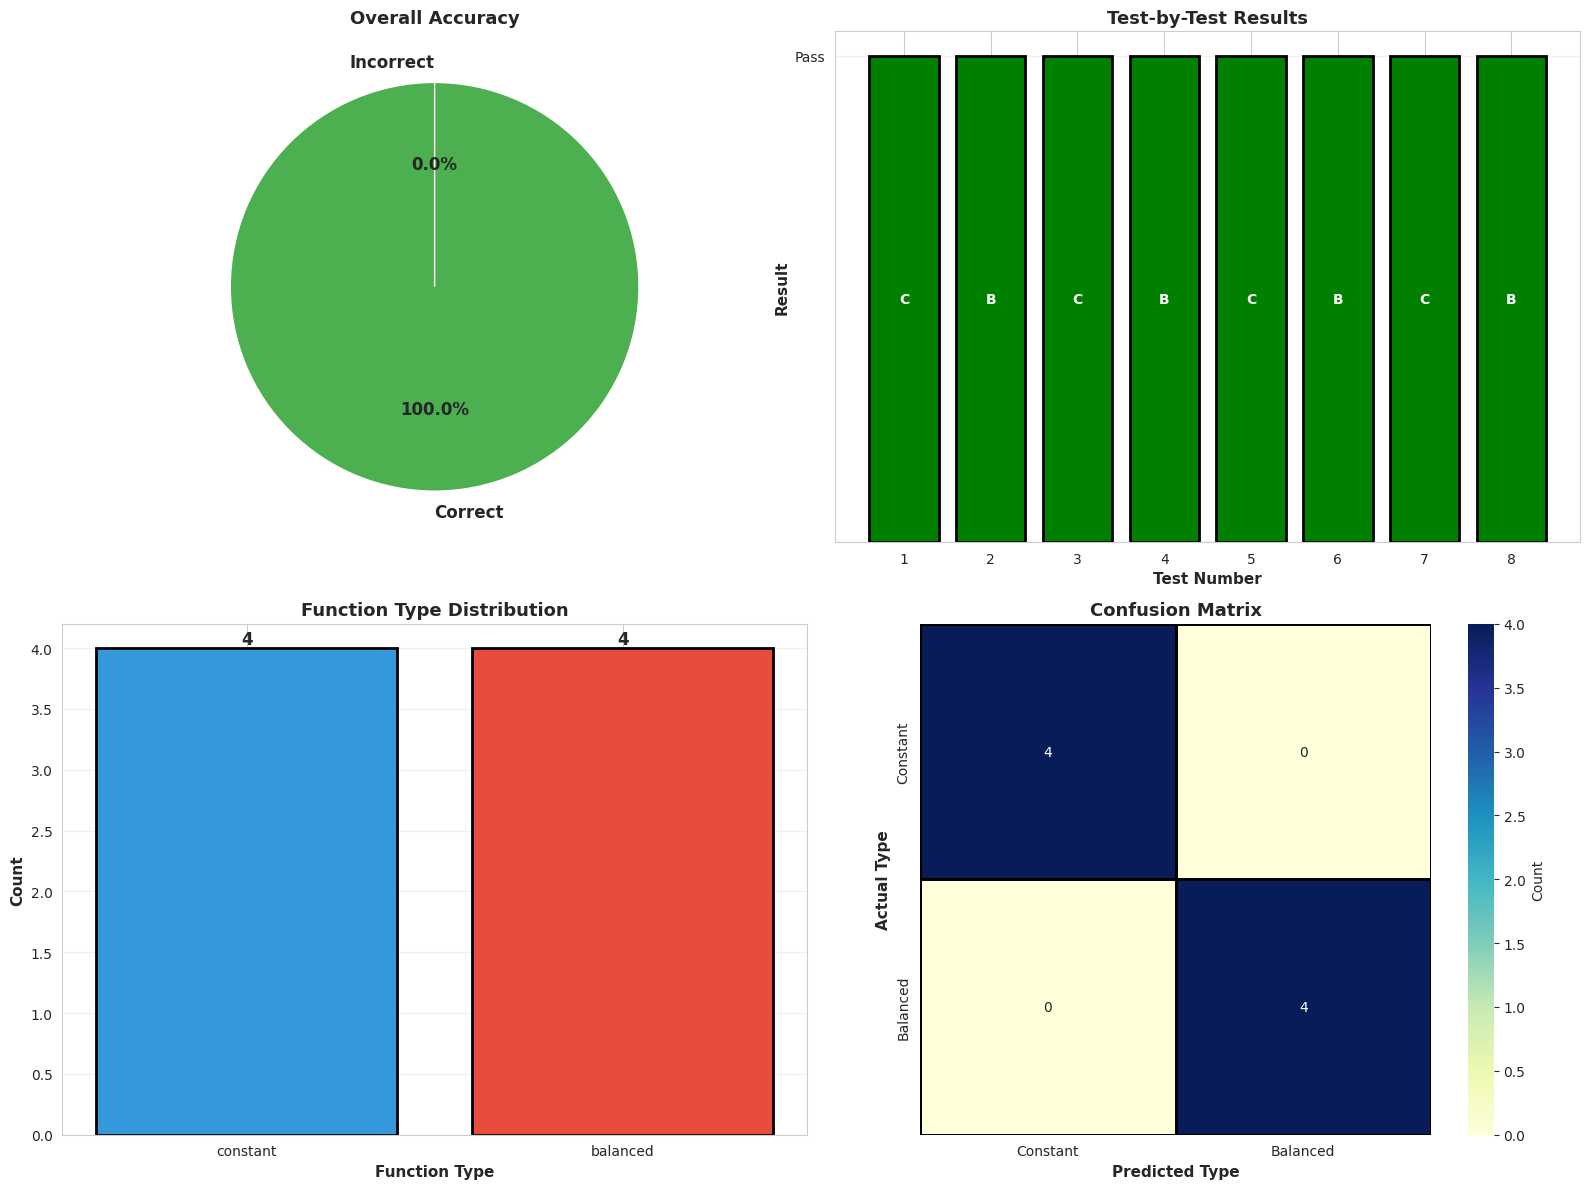

💾 All measurements saved as 'dj_all_measurements.png'


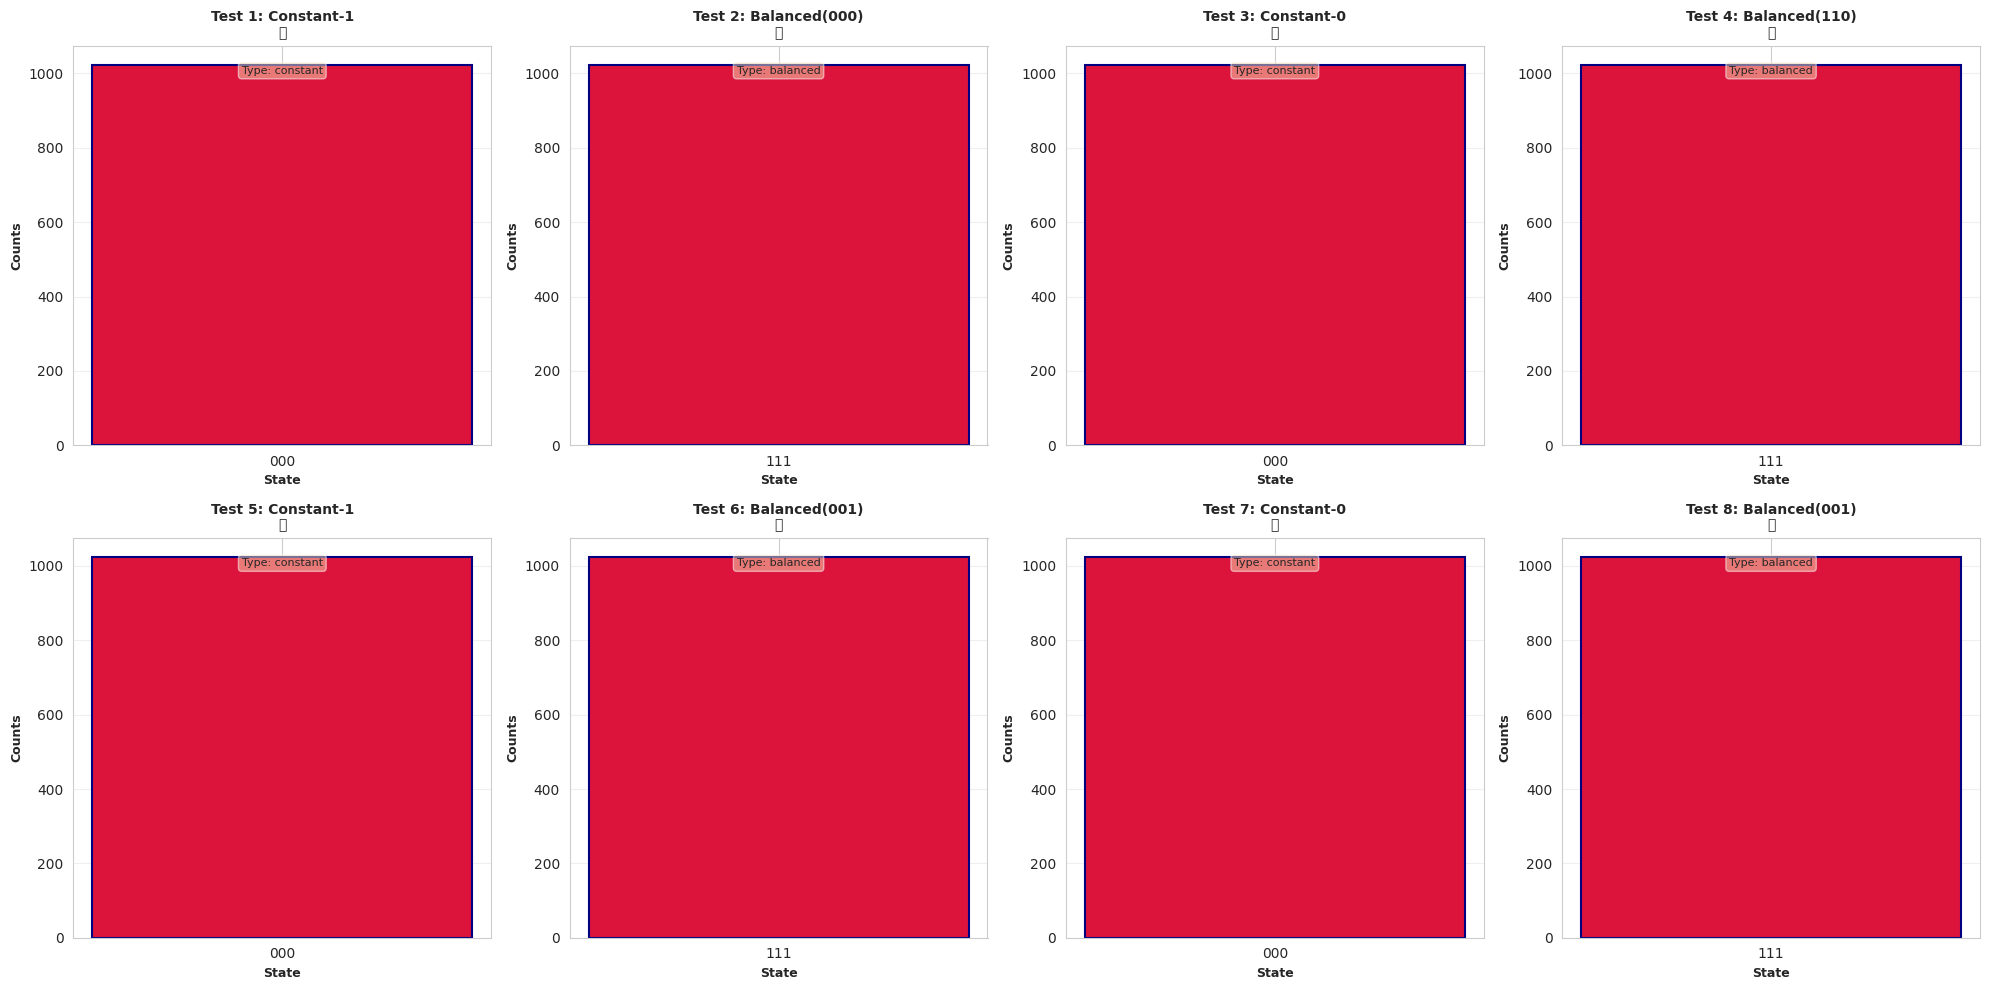


📐 Displaying quantum circuits for first 4 tests...
💾 Sample circuits saved as 'dj_circuits_sample.png'


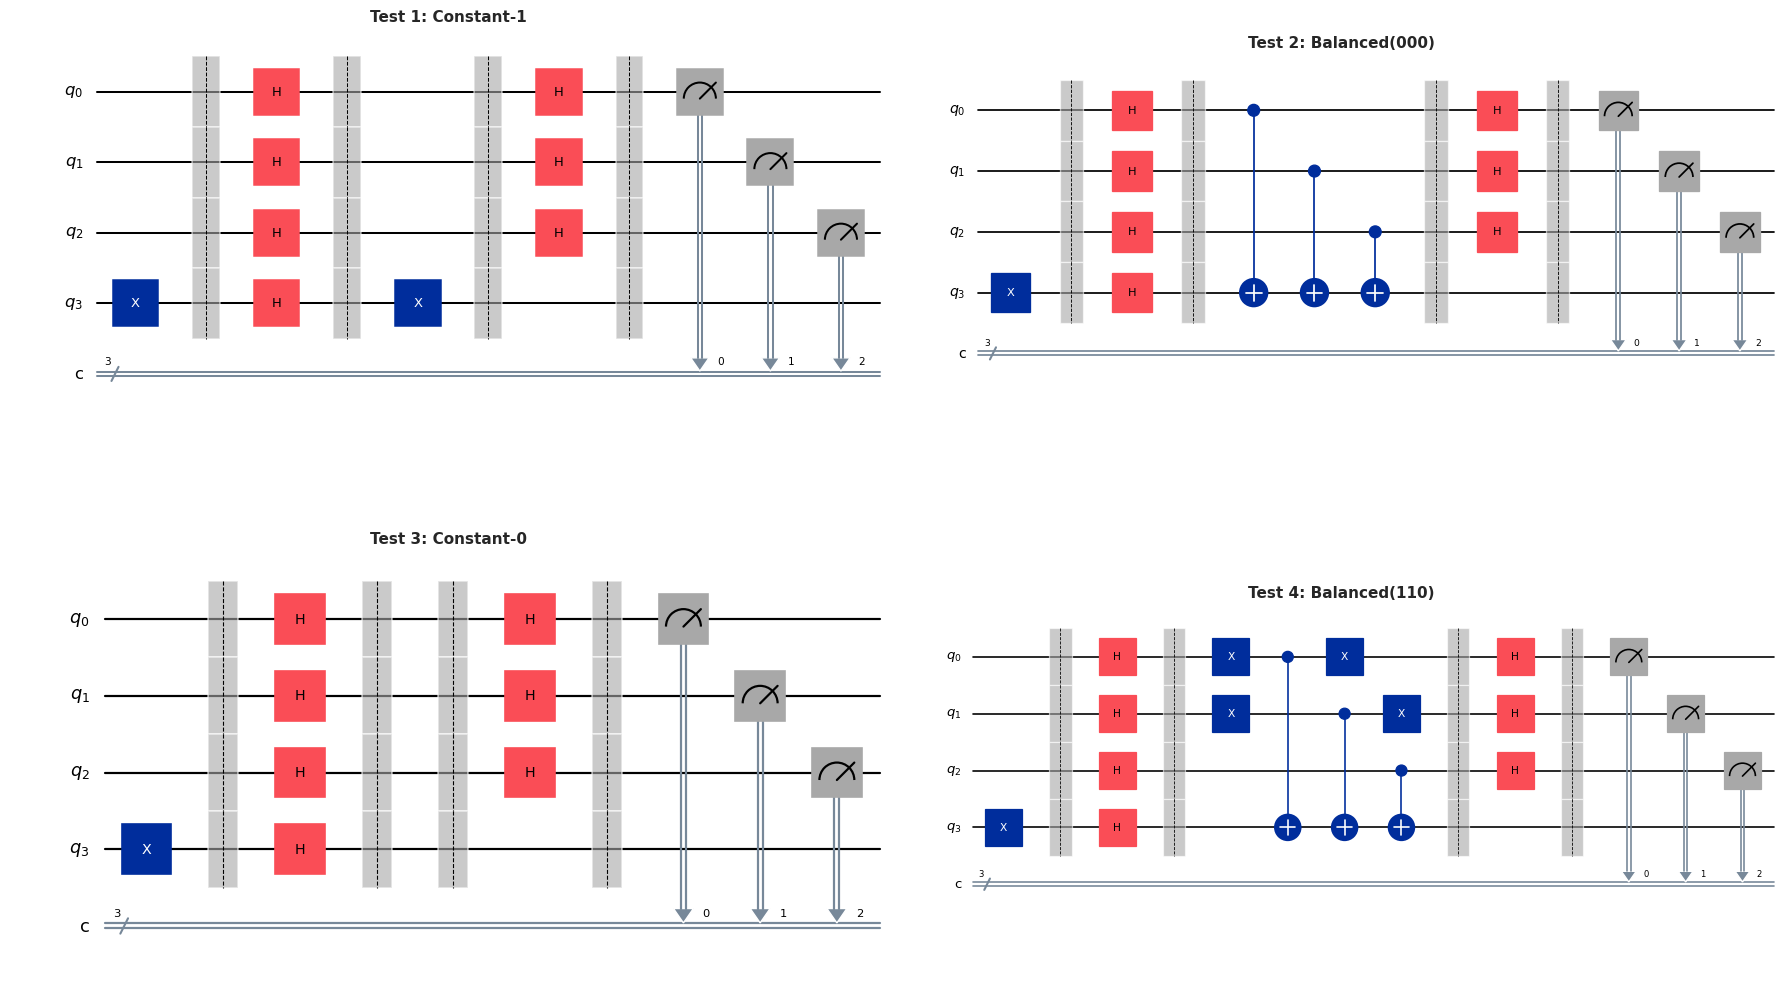

In [7]:
# =============================================================================
# BLOCK 9: COMPREHENSIVE VISUALIZATION
# =============================================================================

print("\n\n📊 BLOCK 7: COMPREHENSIVE VISUALIZATION")
print("="*70)

# Create results DataFrame
df = pd.DataFrame(test_results)

# Figure 1: Test Results Overview
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Success/Failure pie chart
ax1 = axes[0, 0]
success_counts = df['Correct'].value_counts()
colors_pie = ['#4CAF50', '#F44336']
labels_pie = ['Correct', 'Incorrect']
wedges, texts, autotexts = ax1.pie(
    [success_counts.get(True, 0), success_counts.get(False, 0)],
    labels=labels_pie,
    colors=colors_pie,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
ax1.set_title('Overall Accuracy', fontsize=13, fontweight='bold')

# 2. Test-by-test results
ax2 = axes[0, 1]
test_numbers = df['Test'].values
colors_bar = ['green' if c else 'red' for c in df['Correct']]
bars = ax2.bar(test_numbers, [1]*len(test_numbers), color=colors_bar, 
               edgecolor='black', linewidth=2)
ax2.set_xlabel('Test Number', fontsize=11, fontweight='bold')
ax2.set_ylabel('Result', fontsize=11, fontweight='bold')
ax2.set_title('Test-by-Test Results', fontsize=13, fontweight='bold')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['', 'Pass'])
ax2.set_xticks(test_numbers)
ax2.grid(True, alpha=0.3, axis='y')

# Add function type labels
for i, (test, func_type) in enumerate(zip(test_numbers, df['Actual Type'])):
    label = 'C' if func_type == 'constant' else 'B'
    ax2.text(test, 0.5, label, ha='center', va='center', 
            fontsize=10, fontweight='bold', color='white')

# 3. Function type distribution
ax3 = axes[1, 0]
type_counts = df['Actual Type'].value_counts()
bars3 = ax3.bar(type_counts.index, type_counts.values, 
               color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=2)
ax3.set_xlabel('Function Type', fontsize=11, fontweight='bold')
ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
ax3.set_title('Function Type Distribution', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. Confusion matrix style visualization
ax4 = axes[1, 1]
confusion_data = np.zeros((2, 2))
for _, row in df.iterrows():
    actual_idx = 0 if row['Actual Type'] == 'constant' else 1
    predicted_idx = 0 if row['Predicted Type'] == 'constant' else 1
    confusion_data[actual_idx][predicted_idx] += 1

sns.heatmap(confusion_data, annot=True, fmt='g', cmap='YlGnBu', 
           cbar_kws={'label': 'Count'}, ax=ax4, linewidths=2, 
           linecolor='black', square=True,
           xticklabels=['Constant', 'Balanced'],
           yticklabels=['Constant', 'Balanced'])
ax4.set_xlabel('Predicted Type', fontsize=11, fontweight='bold')
ax4.set_ylabel('Actual Type', fontsize=11, fontweight='bold')
ax4.set_title('Confusion Matrix', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('dj_test_results_overview.png', dpi=300, bbox_inches='tight')
print("💾 Test results overview saved as 'dj_test_results_overview.png'")
plt.show()

# =============================================================================
# Figure 2: Measurement Distributions
# =============================================================================

fig2, axes2 = plt.subplots(2, 4, figsize=(20, 10))
axes2 = axes2.flatten()

for idx, result in enumerate(test_results):
    ax = axes2[idx]
    counts = result['Counts']
    
    # Create bar plot
    states = list(counts.keys())
    values = list(counts.values())
    colors_bar = ['crimson' if s == result['Measured State'] else 'steelblue' 
                  for s in states]
    
    ax.bar(states, values, color=colors_bar, edgecolor='navy', linewidth=1.5)
    ax.set_xlabel('State', fontsize=9, fontweight='bold')
    ax.set_ylabel('Counts', fontsize=9, fontweight='bold')
    
    # Title with status
    status = "✅" if result['Correct'] else "❌"
    title = f"Test {result['Test']}: {result['Function'][:15]}\n{status}"
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add annotation
    ax.text(0.5, 0.95, f"Type: {result['Actual Type']}", 
           transform=ax.transAxes, ha='center', va='top',
           fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('dj_all_measurements.png', dpi=300, bbox_inches='tight')
print("💾 All measurements saved as 'dj_all_measurements.png'")
plt.show()

# =============================================================================
# Figure 3: Quantum Circuits for Selected Tests
# =============================================================================

print("\n📐 Displaying quantum circuits for first 4 tests...")

fig3, axes3 = plt.subplots(2, 2, figsize=(18, 12))
axes3 = axes3.flatten()

for idx in range(min(4, len(test_results))):
    result = test_results[idx]
    circuit = deutsch_jozsa_algorithm(result['Oracle'], n_qubits)
    
    circuit.draw('mpl', ax=axes3[idx], style='iqp', fold=20)
    title = f"Test {result['Test']}: {result['Function']}"
    axes3[idx].set_title(title, fontsize=11, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('dj_circuits_sample.png', dpi=300, bbox_inches='tight')
print("💾 Sample circuits saved as 'dj_circuits_sample.png'")
plt.show()





📈 BLOCK 8: STATISTICAL ANALYSIS

📊 DETAILED STATISTICS:
----------------------------------------------------------------------
Total tests run: 8
Number of qubits: 3
Shots per test: 1024
Total quantum operations: 8

Constant Functions:
  - Total: 4
  - Correctly identified: 4
  - Accuracy: 100.0%

Balanced Functions:
  - Total: 4
  - Correctly identified: 4
  - Accuracy: 100.0%

⚡ EFFICIENCY COMPARISON:
----------------------------------------------------------------------
Classical approach (worst case):
  - Queries per function: 5
  - Total queries: 40

Quantum approach (DJ Algorithm):
  - Queries per function: 1
  - Total queries: 8

Speedup factor: 5x

💾 Efficiency comparison saved as 'dj_efficiency_comparison.png'


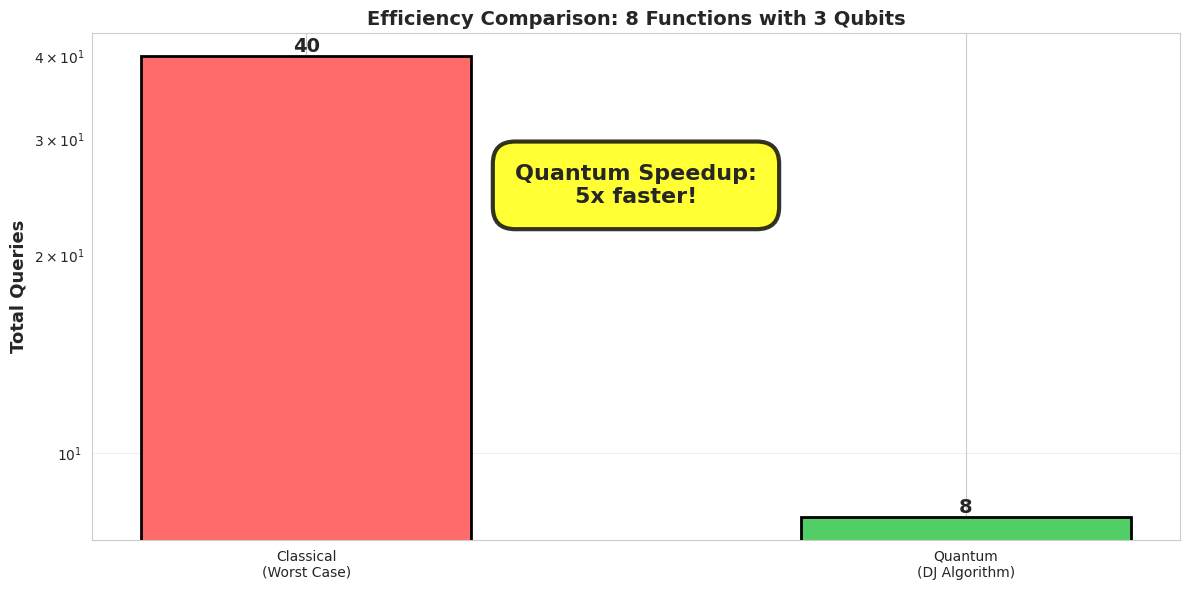


✅ ALL TESTS COMPLETE!

🎉 FINAL SUMMARY:
  - Tests passed: 8/8
  - Success rate: 100.0%
  - Quantum advantage: 5x speedup
  - All visualizations saved successfully!


In [8]:
# =============================================================================
# BLOCK 10: STATISTICAL ANALYSIS
# =============================================================================

print("\n\n📈 BLOCK 8: STATISTICAL ANALYSIS")
print("="*70)

# Detailed statistics
print(f"\n📊 DETAILED STATISTICS:")
print("-" * 70)
print(f"Total tests run: {n_tests}")
print(f"Number of qubits: {n_qubits}")
print(f"Shots per test: 1024")
print(f"Total quantum operations: {n_tests}")

constant_tests = df[df['Actual Type'] == 'constant']
balanced_tests = df[df['Actual Type'] == 'balanced']

print(f"\nConstant Functions:")
print(f"  - Total: {len(constant_tests)}")
print(f"  - Correctly identified: {constant_tests['Correct'].sum()}")
print(f"  - Accuracy: {constant_tests['Correct'].sum()/len(constant_tests)*100:.1f}%")

print(f"\nBalanced Functions:")
print(f"  - Total: {len(balanced_tests)}")
print(f"  - Correctly identified: {balanced_tests['Correct'].sum()}")
print(f"  - Accuracy: {balanced_tests['Correct'].sum()/len(balanced_tests)*100:.1f}%")

# Classical vs Quantum comparison
classical_queries = (2**(n_qubits-1) + 1) * n_tests
quantum_queries = n_tests

print(f"\n⚡ EFFICIENCY COMPARISON:")
print("-" * 70)
print(f"Classical approach (worst case):")
print(f"  - Queries per function: {2**(n_qubits-1) + 1}")
print(f"  - Total queries: {classical_queries}")

print(f"\nQuantum approach (DJ Algorithm):")
print(f"  - Queries per function: 1")
print(f"  - Total queries: {quantum_queries}")

print(f"\nSpeedup factor: {classical_queries/quantum_queries:.0f}x")

# Visualization of efficiency
fig4, ax = plt.subplots(1, 1, figsize=(12, 6))

methods = ['Classical\n(Worst Case)', 'Quantum\n(DJ Algorithm)']
queries_list = [classical_queries, quantum_queries]
colors_eff = ['#ff6b6b', '#51cf66']

bars = ax.bar(methods, queries_list, color=colors_eff, 
             edgecolor='black', linewidth=2, width=0.5)
ax.set_ylabel('Total Queries', fontsize=13, fontweight='bold')
ax.set_title(f'Efficiency Comparison: {n_tests} Functions with {n_qubits} Qubits', 
            fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, queries_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(val)}',
           ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add speedup box
speedup_text = f'Quantum Speedup:\n{classical_queries/quantum_queries:.0f}x faster!'
ax.text(0.5, 0.7, speedup_text, transform=ax.transAxes,
       fontsize=16, fontweight='bold',
       bbox=dict(boxstyle='round,pad=1', facecolor='yellow', 
                edgecolor='black', linewidth=3, alpha=0.8),
       ha='center', va='center')

plt.tight_layout()
plt.savefig('dj_efficiency_comparison.png', dpi=300, bbox_inches='tight')
print("\n💾 Efficiency comparison saved as 'dj_efficiency_comparison.png'")
plt.show()

print("\n" + "="*70)
print("✅ ALL TESTS COMPLETE!")
print("="*70)
print(f"\n🎉 FINAL SUMMARY:")
print(f"  - Tests passed: {sum([r['Correct'] for r in test_results])}/{n_tests}")
print(f"  - Success rate: {success_rate:.1f}%")
print(f"  - Quantum advantage: {classical_queries/quantum_queries:.0f}x speedup")
print(f"  - All visualizations saved successfully!")
print("="*70)